In [54]:
## Imports needed 
from bs4 import BeautifulSoup
from collections import defaultdict
import pickle
import requests
from unidecode import unidecode
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import time

# data manipulation/visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# modeling and blackbox analysis
from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier as XGBC
import shap
from pdpbox import pdp 

# classification metrics and utils
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, plot_confusion_matrix

# basic utils
import os.path
import pickle
from math import exp




pd.options.mode.chained_assignment = None  # default='warn'

GPU = False
tree_method = 'gpu_hist' if GPU else 'auto'

# Data Collection

In [19]:
## ASG Web Scraping, asg_scrape.py

# this dictionary will map all players to a set containing all of their all star year appearance (Selected and/or injury replacement)
all_star_appearances = defaultdict(set)

# rows to ignore when iterating over roster table
ignore_fields = ["Reserves", "Team Totals"]

START_YEAR, END_YEAR = 1970, 2020

# unidecode doesn't catch the accented c in Peja's last name (Stojakovice). fix it
# also overwrite any instance of Metta World Peace to Ron Artest

def fix_name(full_name):
    first_name = full_name.split(' ')[0]
    if first_name == 'Peja':
        return "Peja Stojakovic"
    elif first_name =='Metta':
        return 'Ron Artest'
    else:
        return unidecode(full_name)
    
# Scrape All-Star Rosters from START_YEAR to END_YEAR
for year in range(START_YEAR, END_YEAR):
    
    # no ASG in 1999 due to lockout
    if year == 1999:
        continue
        
    print('Scraping ASG {} data...'.format(year))
    
    # store the all_stars for this year
    all_stars = set([])
    
    html = requests.get('https://www.basketball-reference.com/allstar/NBA_{}.html'.format(year)).content
    soup = BeautifulSoup(html, 'html.parser')
    
    # gets rosters for team 1 and team 2
    s1, s2 = soup.findAll('table')[1:3]
    
    df1 = pd.read_html(str(s1))[0]
    df2 = pd.read_html(str(s2))[0]
    
    # get all stars from team 1 and 2
    for df in [df1, df2]:
        for i, row in df.iterrows():
            if pd.notnull(row[0]) and row[0] not in ignore_fields:
                player = row[0]
                all_stars.add(fix_name(player))
                
    # get all-star that DNP-injury
    s3 = soup.findAll('li')
    for s in s3:
        if "Did not play" in str(s):
            for player in [name.get_text() for name in s.findAll('a')]: # all injured players
                all_stars.add(fix_name(player))
            break
    
    # update the all_star_appearances_dictionary
    for player in all_stars:
        all_star_appearances[player].add(year)
    
sorted_all_star_appearances = sorted([(player, sorted(list(appearances))) for player, appearances in all_star_appearances.items()], key = lambda x : -len(x[1]))

print('\nAll all-star appearances since {} (sorted by number of appearances):\n'.format(START_YEAR))

for player, appearances in sorted_all_star_appearances:
    print('{}: {}'.format(player, appearances))
    
# export the dictionary to local disk for future recall
out = open('all_star_appearances.pickle', 'wb')
pickle.dump(all_star_appearances, out)
out.close

Scraping ASG 1970 data...
Scraping ASG 1971 data...
Scraping ASG 1972 data...
Scraping ASG 1973 data...
Scraping ASG 1974 data...
Scraping ASG 1975 data...
Scraping ASG 1976 data...
Scraping ASG 1977 data...
Scraping ASG 1978 data...
Scraping ASG 1979 data...
Scraping ASG 1980 data...
Scraping ASG 1981 data...
Scraping ASG 1982 data...
Scraping ASG 1983 data...
Scraping ASG 1984 data...
Scraping ASG 1985 data...
Scraping ASG 1986 data...
Scraping ASG 1987 data...
Scraping ASG 1988 data...
Scraping ASG 1989 data...
Scraping ASG 1990 data...
Scraping ASG 1991 data...
Scraping ASG 1992 data...
Scraping ASG 1993 data...
Scraping ASG 1994 data...
Scraping ASG 1995 data...
Scraping ASG 1996 data...
Scraping ASG 1997 data...
Scraping ASG 1998 data...
Scraping ASG 2000 data...
Scraping ASG 2001 data...
Scraping ASG 2002 data...
Scraping ASG 2003 data...
Scraping ASG 2004 data...
Scraping ASG 2005 data...
Scraping ASG 2006 data...
Scraping ASG 2007 data...
Scraping ASG 2008 data...
Scraping ASG

<function BufferedWriter.close>

In [98]:
# Historical Stats Scrape from NBA Stats site

START_YEAR, END_YEAR = 1996, 2020

# list of DataFrames for historical data, one for each year
df_train_master = []

# DataFrame containing features for the current year which will be used to 
# estimate ASG selection probabilities
df_to_predict = pd.DataFrame()

# lets us look up team record and rank by (year,team)
# we need this to augment our player dataset
team_rank_historical_lookup = {}

# load the all-star history dictionary that we generated previously
all_star_appearances = pickle.load(open('all_star_appearances.pickle', 'rb'))

# we need a map from the team's full name to their short form (prefix)
team_prefix = {
    'Atlanta Hawks' : 'ATL',
    'Boston Celtics' : 'BOS',
    'Charlotte Hornets Old' : 'CHH', # deprecated
    'Chicago Bulls' : 'CHI',
    'Cleveland Cavaliers' : 'CLE',
    'Dallas Mavericks' : 'DAL',
    'Denver Nuggets' : 'DEN',
    'Detroit Pistons' : 'DET',
    'Golden State Warriors' : 'GSW',
    'Houston Rockets' : 'HOU',
    'Indiana Pacers' : 'IND',
    'Los Angeles Clippers' : 'LAC', # deprecated
    'LA Clippers' : 'LAC',
    'Los Angeles Lakers' : 'LAL',
    'Miami Heat' : 'MIA',
    'Milwaukee Bucks' : 'MIL',
    'Minnesota Timberwolves' : 'MIN',
    'New Jersey Nets' : 'NJN', # deprecated
    'New York Knicks' : 'NYK',
    'Orlando Magic' : 'ORL',
    'Philadelphia 76ers' : 'PHI',
    'Phoenix Suns' : 'PHX',
    'Portland Trail Blazers' : 'POR',
    'Sacramento Kings' : 'SAC',
    'San Antonio Spurs' : 'SAS',
    'Seattle SuperSonics' : 'SEA', # deprecated
    'Toronto Raptors' : 'TOR',
    'Utah Jazz' : 'UTA',
    'Vancouver Grizzlies' : 'VAN', # deprecated
    'Washington Bullets' : 'WAS', # deprecated
    'Washington Wizards' : 'WAS',
    'Memphis Grizzlies' : 'MEM',
    'New Orleans Hornets' : 'NOH', # deprecated
    'Charlotte Bobcats' : 'CHA', # deprecated
    'New Orleans/Oklahoma City Hornets' : 'NOK', # deprecated
    'Oklahoma City Thunder' : 'OKC',
    'Brooklyn Nets' : 'BKN',
    'Charlotte Hornets New' : 'CHA',
    'New Orleans Pelicans' : 'NOP'
}

def adjust_hornets(row):
    if row['TEAM'] == 'Charlotte Hornets':
        return 'Charlotte Hornets Old' if row['Year'] <= 2001 else 'Charlotte Hornets New'
    return row['TEAM']

# function will construct our team rank lookup by year
def fill_team_rank_historical_lookup(row):
    year = row['Year']
    team = row['TEAM']
    rank = row['Conference Rank']
    gp = row['GP']
    prefix = team_prefix[team]
    if year not in team_rank_historical_lookup:
        team_rank_historical_lookup[year] ={}
    team_rank_historical_lookup[year][prefix] = (rank, gp)
    
# we also need average league pace by year, so we can normalize all statistics to be pace-adjusted
html = requests.get('https://www.basketball-reference.com/leagues/NBA_stats_per_game.html').content
s_pace = BeautifulSoup(html, 'html.parser')

pace_table = s_pace.find('table')
df_pace = pd.read_html(str(pace_table))[0]
df_pace.columns = df_pace.columns.droplevel()

#maps year to league average pace
pace_lookup = {}

for i, row in df_pace.iterrows():
    if pd.isnull(row['Season']) or row['Season'] == 'Season':
        continue
    year = int(row['Season'][:4])
    pace_lookup[year] = row['Pace']
    if year == START_YEAR:
        break
        
# this function looks up if a player was selected for the ASG in the prior year
def was_AS_last_year(row):
    if row['Year'] == 1999:
        return 1 if 1998 in all_star_appearances[row['PLAYER']] else 0
    return 1 if row['Year'] in all_star_appearances[row['PLAYER']] else 0

# initialize the chromedriver
d = webdriver.Chrome('./chromedriver')

# crude time delay to wait before attempting to scrape tabular data after XML document has loaded
TIME_DELAY_TEAMS = 3
TIME_DELAY_PLAYERS = 10

for year in range(START_YEAR, END_YEAR):
    
    if year ==1998: #lockout
        continue
        
    start_date = (10, 1, year)
    end_date = (1, 21, year+1)
    
    season_label = str(year) + '-' + str(year+1)[2:]
    print('Scraping stats.nba.com for {} season...'.format(season_label))
    
    # contains the majority of our desired statistics (PTS, REB, AST, etc.)
    url_players_traditional = '''https://stats.nba.com/players/traditional/?Season={}&SeasonType=Regular%20Season&sort=PTS&dir=-1&DateFrom={}%2F{}%2F{}&DateTo={}%2F{}%2F{}'''.format(season_label, *start_date, *end_date)
    
    # contains advanced statistics (TS%, USG%, PIE)
    url_players_advanced = '''https://stats.nba.com/players/advanced/?Season={}&SeasonType=Regular%20Season&sort=PTS&dir=-1&DateFrom={}%2F{}%2F{}&DateTo={}%2F{}%2F{}'''.format(season_label, *start_date, *end_date)

    # contains DEFWS (defensive win-shares)
    url_players_defense = '''https://stats.nba.com/players/defense/?Season={}&SeasonType=Regular%20Season&sort=DEF_WS&dir=-1&DateFrom={}%2F{}%2F{}&DateTo={}%2F{}%2F{}'''.format(season_label, *start_date, *end_date)
    
    # contains team rankings by conference at any instance of time
    url_teams = '''https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season={}&SeasonType=Regular%20Season&Conference={}&DateFrom={}%2F{}%2F{}&DateTo={}%2F{}%2F{}'''
    
    for conf in ['East', 'West']:
        d.get(url_teams.format(season_label, conf, *start_date, *end_date))
        
        # make sure element is loaded
        time.sleep(TIME_DELAY_TEAMS)
        
        s_teams = BeautifulSoup(d.page_source, 'html.parser').find('table')
        df = pd.read_html(str(s_teams))[0]
        df['Year'] = year
        df['Conference'] = conf
        df.rename(columns={'Unnamed: 0': 'Conference Rank'}, inplace=True)
        
        df['TEAM'] = df[['TEAM', 'Year']].apply(adjust_hornets, axis=1)
        df[['TEAM', 'Year', 'Conference Rank', 'GP']].apply(fill_team_rank_historical_lookup, axis=1)
        
    d.get(url_players_traditional)
    
    time.sleep(TIME_DELAY_PLAYERS)
    
    # by default, only 50 players are displayed pe page, but we can change this using the dropdown select element
    select = Select(d.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select'))
    select.select_by_visible_text('All')
    
    s_traditional = BeautifulSoup(d.page_source, 'html.parser').find('table')
    
    d.get(url_players_advanced)
    
    time.sleep(TIME_DELAY_PLAYERS)
    
    select = Select(d.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select'))
    select.select_by_visible_text('All')

    s_advanced = BeautifulSoup(d.page_source, 'html.parser').find('table')

    d.get(url_players_defense)

    time.sleep(TIME_DELAY_PLAYERS)

    select = Select(d.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select'))
    select.select_by_visible_text('All')

    s_defense = BeautifulSoup(d.page_source, 'html.parser').find('table')
    
    df_traditional = pd.read_html(str(s_traditional))[0].dropna(subset=['PLAYER'])
    df_advanced = pd.read_html(str(s_advanced))[0].dropna(subset=['PLAYER'])
    df_defense = pd.read_html(str(s_defense))[0].rename(columns={'Player' : 'PLAYER'}).dropna(subset=['PLAYER'])
    
    # merge all above dataframes
    df = df_traditional.merge(df_advanced[['PLAYER', 'TS%', 'USG%', 'PIE']], on='PLAYER')
    df = df.merge(df_defense[['PLAYER', 'DEFWS']], on='PLAYER')
    
    #stitching it all together
    df['Year'] = year
    df['Avg Pace'] = df['Year'].map(lambda x: pace_lookup[x])
    df['Team Conference Rank'] = df[['TEAM', 'Year']].apply(lambda row: team_rank_historical_lookup[row['Year']][row['TEAM']][0], axis =1)
    df['Team GP'] = df[['TEAM', 'Year']].apply(lambda row: team_rank_historical_lookup[row['Year']][row['TEAM']][1], axis=1)
    df['PLAYER'] = df['PLAYER'].map(lambda x: 'Ron Artest' if x=='Metta World Peace' else x)
    df['Prior ASG Appearances'] = df[['PLAYER', 'Year']].apply(lambda row: sum(y<=row['Year'] for y in all_star_appearances[row['PLAYER']]), axis =1)
    df['AS Last Year?'] = df[['PLAYER', 'Year']].apply(was_AS_last_year, axis=1)
    df['Selected?'] = df[['PLAYER', 'Year']].apply(lambda row: 1 if row['Year']+1 in all_star_appearances[row['PLAYER']] else 0, axis=1)
    
    #desired raw features, before any feature engineering/transformation
    df = df[['Year', 'Avg Pace', 'PLAYER', 'TEAM', 'Team Conference Rank', 'GP', 'Team GP', 'W',
                    'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TS%', '3PM', 'DEFWS', 'USG%', 'PIE', 'Prior ASG Appearances', 'AS Last Year?', 'Selected?']]
    
    if year < END_YEAR-1:
        df_train_master.append(df)
    else:
        df_to_predict = df.drop('Selected?', axis=1)
        
d.quit()

pd.concat(df_train_master).to_csv('ASG_train.csv', index=False)
df_to_predict.to_csv('ASG_to_predict.csv', index=False)


Scraping stats.nba.com for 1996-97 season...
Scraping stats.nba.com for 1997-98 season...
Scraping stats.nba.com for 1999-00 season...
Scraping stats.nba.com for 2000-01 season...
Scraping stats.nba.com for 2001-02 season...
Scraping stats.nba.com for 2002-03 season...
Scraping stats.nba.com for 2003-04 season...
Scraping stats.nba.com for 2004-05 season...
Scraping stats.nba.com for 2005-06 season...
Scraping stats.nba.com for 2006-07 season...
Scraping stats.nba.com for 2007-08 season...
Scraping stats.nba.com for 2008-09 season...
Scraping stats.nba.com for 2009-10 season...
Scraping stats.nba.com for 2010-11 season...
Scraping stats.nba.com for 2011-12 season...
Scraping stats.nba.com for 2012-13 season...
Scraping stats.nba.com for 2013-14 season...
Scraping stats.nba.com for 2014-15 season...
Scraping stats.nba.com for 2015-16 season...
Scraping stats.nba.com for 2016-17 season...
Scraping stats.nba.com for 2017-18 season...
Scraping stats.nba.com for 2018-19 season...
Scraping s

# Modelling

## Preprocessing & Addressing Outliers

In [99]:
# check if this is the first time running the script
# if the model exists from a prior execution, we can load the model from memory instead of retraining it from scratch
already_trained_xgb = os.path.exists('./ASG_predictor_XGB.model')
# directory to store plots concerning model evaluation and interpretation
if not os.path.exists('./Plots'):
    os.makedirs('./Plots')

# labeled dataset
df_train = pd.read_csv('ASG_train.csv')

# current year's dataset (unlabelled)
df_to_predict = pd.read_csv('ASG_to_predict.csv')

In [100]:
df_train.head(10)

,Year,Avg Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?,Selected?
0,1996,90.1,Michael Jordan,CHI,1,40,40,35,30.9,5.8,...,0.5,1.7,56.4,1.2,0.004,33.6,19.8,10,1,1
1,1996,90.1,Shaquille O'Neal,LAL,3,40,41,28,26.2,13.2,...,3.1,3.1,55.7,0.0,0.003,30.4,18.4,4,1,1
2,1996,90.1,Latrell Sprewell,GSW,7,39,39,16,25.9,4.9,...,0.8,4.0,57.1,2.2,0.001,28.2,14.5,2,0,1
3,1996,90.1,Karl Malone,UTA,4,40,40,27,25.8,10.8,...,0.7,3.1,57.6,0.0,0.003,31.5,20.8,9,1,1
4,1996,90.1,Hakeem Olajuwon,HOU,1,37,41,28,24.1,9.4,...,2.2,3.7,54.8,0.1,0.003,32.2,16.3,11,1,1
5,1996,90.1,Mitch Richmond,SAC,8,40,40,16,24.1,3.9,...,0.3,2.8,56.0,1.8,0.002,28.4,14.3,4,1,1
6,1996,90.1,Glen Rice,CHH,6,37,40,21,24.0,4.2,...,0.4,2.2,57.8,2.5,0.002,25.4,11.3,1,1,1
7,1996,90.1,Allen Iverson,PHI,15,34,39,7,22.8,4.5,...,0.4,4.9,50.3,2.2,0.000,29.0,10.3,0,0,0
8,1996,90.1,Vin Baker,MIL,10,36,39,18,22.4,10.7,...,1.4,3.6,56.2,0.2,0.003,26.9,14.2,2,1,1
9,1996,90.1,Gary Payton,SEA,2,40,40,29,22.2,4.4,...,0.1,2.5,55.1,1.4,0.004,26.0,15.6,3,1,1


In [101]:
df_to_predict.head(10)

,Year,Avg Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,STL,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?
0,2019,100.3,James Harden,HOU,6,41,42,26,36.9,6.3,...,1.6,0.9,4.7,62.1,4.8,0.003,37.0,19.4,7,1
1,2019,100.3,Giannis Antetokounmpo,MIL,1,42,45,36,30.0,12.9,...,1.1,1.0,3.6,61.3,1.6,0.004,36.7,23.3,3,1
2,2019,100.3,Trae Young,ATL,15,40,44,9,29.2,4.7,...,1.2,0.1,4.8,59.4,3.5,0.001,33.8,16.4,0,0
3,2019,100.3,Luka Doncic,DAL,5,39,43,25,29.1,9.7,...,1.0,0.2,4.3,59.7,3.0,0.002,36.1,20.6,0,0
4,2019,100.3,Damian Lillard,POR,10,43,45,19,27.9,4.1,...,1.0,0.3,2.8,60.8,3.6,0.002,28.8,16.2,4,1
5,2019,100.3,Bradley Beal,WAS,11,35,42,10,27.2,4.5,...,1.0,0.3,3.3,55.6,2.5,-0.001,31.8,12.6,2,1
6,2019,100.3,Kawhi Leonard,LAC,2,34,44,26,27.1,7.4,...,2.0,0.6,3.2,57.5,1.9,0.003,33.8,19.2,3,1
7,2019,100.3,Devin Booker,PHX,11,40,43,18,26.8,4.1,...,0.8,0.2,3.9,63.2,1.9,0.002,29.0,14.1,0,0
8,2019,100.3,Anthony Davis,LAL,1,36,43,29,26.6,9.3,...,1.5,2.6,2.4,60.5,1.1,0.003,28.6,18.0,6,1
9,2019,100.3,Kyrie Irving,BKN,8,15,42,5,26.5,5.3,...,1.4,0.5,2.2,56.8,2.5,0.001,31.5,16.8,6,1


In [102]:
# pull out the currentseason from the df for file naming purposes
prediction_year = df_to_predict.loc[0, 'Year'] + 1

#save the PLAYER and TEAM columns for later
# these features get dropped for the prediction process but we will add them back in later for traceability
names_and_teams = df_to_predict[['PLAYER', 'TEAM']]

# manually purging some outliers that are polluting the training data since training set is small
# 
# these players fall into either one or both of the following cases:
#     A: had long, illustrious careers and were selected in their twilight years as a sort of "farewell",
#        despite not playing at an All-Star level
#     B: sat out way too many games of this season and were only selected due to overpowering clout/fan 
#        favouritism
#
# Note: 'Year' in this dataset refers to the calendar year in which the season started, so the ASG in question
#       will be equal to 'Year' + 1
outliers = set([
    ('Dirk Nowitzki', 2018), # A: basically a career tribute
    ('Dwyane Wade', 2018), # A: same as above
    ('Kobe Bryant', 2015), # A
    ('Kobe Bryant', 2013), # A/B
    ('Yao Ming', 2010), # B: Fans went crazy and rallied for him despite playing 5 games
    ('Allen Iverson', 2009), # A
    ('Allen Iverson', 2008), # A
    ("Shaquille O'Neal", 2006), # A/B
    ('Ray Allen', 2003), # B
    ('Jamal Magloire', 2003), # infamous bad selection
    ('Vince Carter', 2002), # B
    ('Grant Hill', 2000), # B
    ('Anfernee Hardaway', 1997), #A/B
    ('Anfernee Hardaway', 1996) #A/B
])

# stores the indices of the outliers above
outlier_indices = []

# gather outlier indices
def process_outliers(row):
    if (row['PLAYER'], row['Year']) in outliers:
        outlier_indices.append(row.name)

# reject the outliers
df_train[['PLAYER', 'Year']].apply(process_outliers, axis=1)
df_train.drop(outlier_indices, inplace=True)

# Further Processing
for df in [df_train, df_to_predict]:
    #drop any player who has played less than 7 games
    df.drop(df[df['GP'] < 7].index, inplace=True)
    
    # Add a 'Play Pct' field with a ceiling of 1
    df['Play Pct'] = (df['GP']/df['Team GP']).map(lambda pct: min(pct, 1))
    
    # Adjust Traditional Stats with Pace in Given Year
    for col in ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', '3PM']:
        df['Adjusted ' + col] = df[col]*100/df['Avg Pace']
    
    # Normalize stats for SVM
    #for col in ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', '3PM', 'DEFWS', 'TS%', 'USG%', 'PIE', 'Play Pct']
        
full_features=[
    'Adjusted PTS',
    'Adjusted REB',
    'Adjusted AST',
    'Adjusted STL',
    'Adjusted BLK',
    'Adjusted TOV',
    'Adjusted 3PM',
    'DEFWS',
    'TS%',
    'USG%',
    'PIE',
    'Play Pct',
    'Team Conference Rank',
    'Prior ASG Appearances',
    'AS Last Year?'
]

# final features used in the model
#
# commented features didn't make the cut
features=[
    'Adjusted PTS',
    'Adjusted REB',
    'Adjusted AST',
    #'Adjusted STL',
    'Adjusted BLK',
    #'Adjusted TOV',
    #'Adjusted 3PM',
    'DEFWS',
    #'TS%',
    'USG%',
    'PIE',
    'Play Pct',
    'Team Conference Rank',
    'Prior ASG Appearances',
    #'AS Last Year?'
]

# abbreviated versions of the feature names for brevity when we get to SHAP analysis
feature_short_labels = [
    'PTS',
    'REB',
    'AST',
    #'STL',
    'BLK',
    #'TOV',
    #'3PM',
    'DEFWS',
    #'TS%',
    'USG%',
    'PIE',
    'PIE',
    'Play%',
    'Team',
    "ASG's",
    #'AS Last Yr'
]

In [103]:
df_train = df_train[full_features + ['Selected?']]
df_train.head(10)

,Adjusted PTS,Adjusted REB,Adjusted AST,Adjusted STL,Adjusted BLK,Adjusted TOV,Adjusted 3PM,DEFWS,TS%,USG%,PIE,Play Pct,Team Conference Rank,Prior ASG Appearances,AS Last Year?,Selected?
0,34.295228,6.437292,4.439512,1.775805,0.554939,1.886792,1.331853,0.004,56.4,33.6,19.8,1.000000,1,10,1,1
1,29.078801,14.650388,3.551609,0.998890,3.440622,3.440622,0.000000,0.003,55.7,30.4,18.4,0.975610,3,4,1,1
2,28.745838,5.438402,6.770255,1.997780,0.887902,4.439512,2.441731,0.001,57.1,28.2,14.5,1.000000,7,2,0,1
3,28.634850,11.986681,5.216426,1.442841,0.776915,3.440622,0.000000,0.003,57.6,31.5,20.8,1.000000,4,9,1,1
4,26.748058,10.432852,2.996670,1.664817,2.441731,4.106548,0.110988,0.003,54.8,32.2,16.3,0.902439,1,11,1,1
5,26.748058,4.328524,4.106548,1.442841,0.332963,3.107658,1.997780,0.002,56.0,28.4,14.3,1.000000,8,4,1,1
6,26.637070,4.661487,2.219756,0.998890,0.443951,2.441731,2.774695,0.002,57.8,25.4,11.3,0.925000,6,1,1,1
7,25.305216,4.994451,7.547170,2.552719,0.443951,5.438402,2.441731,0.000,50.3,29.0,10.3,0.871795,15,0,0,0
8,24.861265,11.875694,2.663707,1.109878,1.553829,3.995560,0.221976,0.003,56.2,26.9,14.2,0.923077,10,2,1,1
9,24.639290,4.883463,7.991121,2.663707,0.110988,2.774695,1.553829,0.004,55.1,26.0,15.6,1.000000,2,3,1,1


# Exploratory Data Analysis

In [104]:
df_train.describe()

,Adjusted PTS,Adjusted REB,Adjusted AST,Adjusted STL,Adjusted BLK,Adjusted TOV,Adjusted 3PM,DEFWS,TS%,USG%,PIE,Play Pct,Team Conference Rank,Prior ASG Appearances,AS Last Year?,Selected?
count,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.00000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000
mean,9.317646,4.079093,2.047695,0.741639,0.484354,1.380204,0.625547,0.001691,51.427964,18.26541,8.603564,0.760861,7.873201,0.497830,0.060886,0.063628
std,6.481031,2.765749,1.985172,0.501842,0.553442,0.893293,0.727648,0.001262,7.408875,4.96941,3.945221,0.249433,4.290881,1.711263,0.239136,0.244103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003000,0.000000,4.30000,-16.700000,0.145833,1.000000,0.000000,0.000000,0.000000
25%,4.224216,2.065217,0.657174,0.332963,0.109890,0.700000,0.000000,0.001000,47.800000,14.80000,6.300000,0.589744,4.000000,0.000000,0.000000,0.000000
50%,7.766990,3.407881,1.401187,0.652174,0.323625,1.194354,0.330033,0.001000,52.100000,17.80000,8.700000,0.853659,8.000000,0.000000,0.000000,0.000000
75%,13.086150,5.390539,2.720348,0.992282,0.638978,1.878453,1.074114,0.002000,55.800000,21.50000,10.900000,0.975610,12.000000,0.000000,0.000000,0.000000
max,38.453039,18.312986,14.223670,3.222342,4.840484,6.016598,5.300000,0.014000,105.000000,40.70000,28.600000,1.000000,15.000000,16.000000,1.000000,1.000000


In [105]:
husl = sns.color_palette('husl')
# 0 = non all-star: red
# 1 = all-star: green
palette = {
    0: husl[0],
    1: husl[1]
}

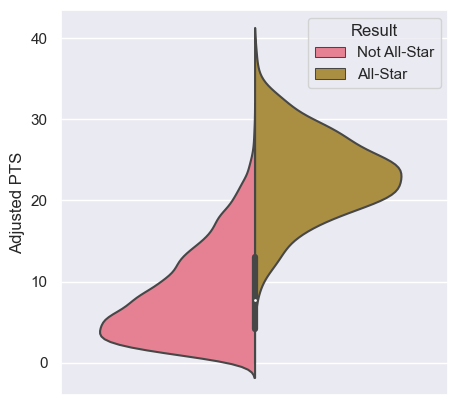

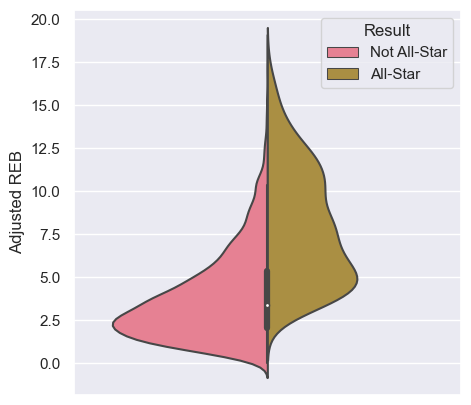

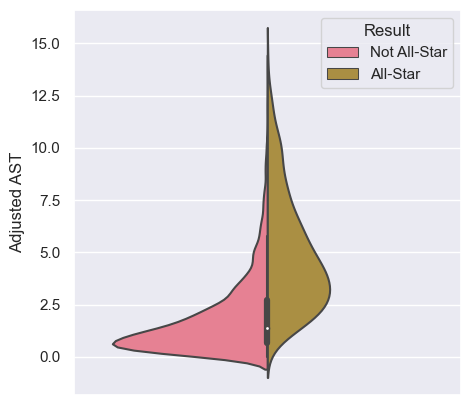

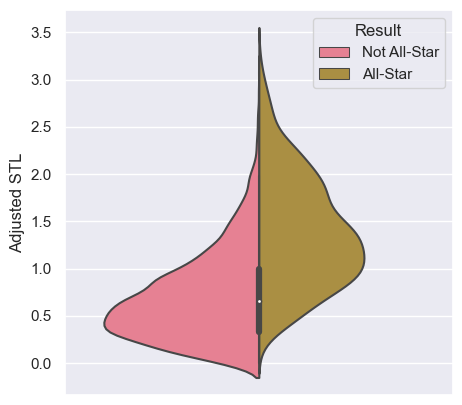

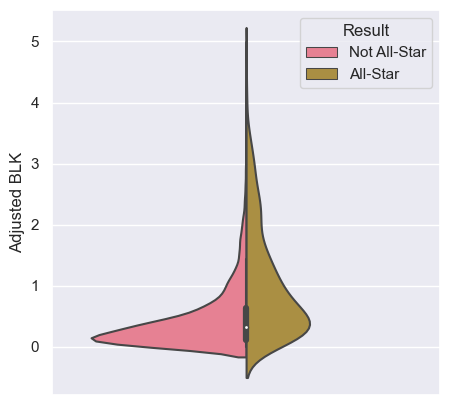

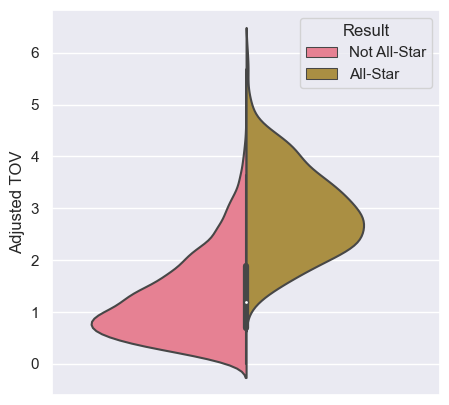

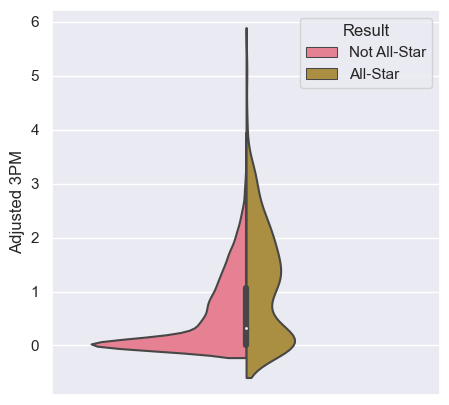

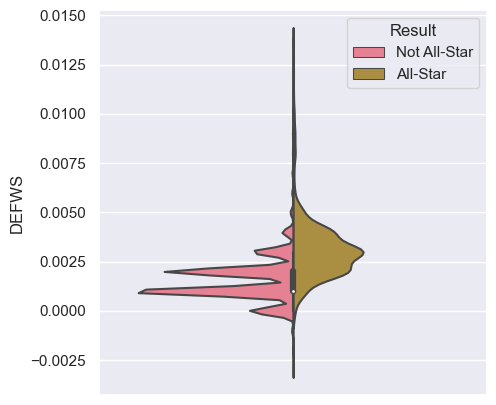

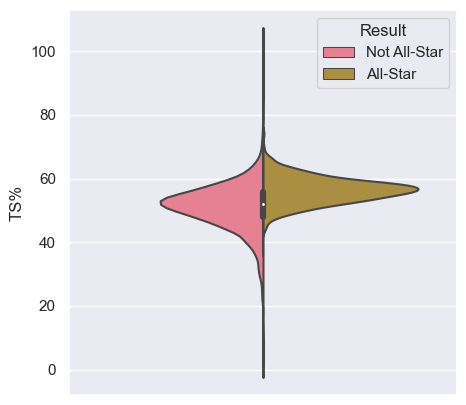

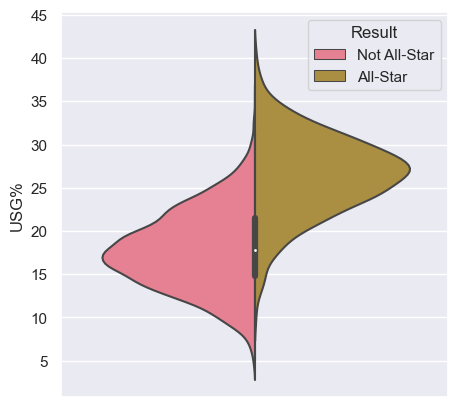

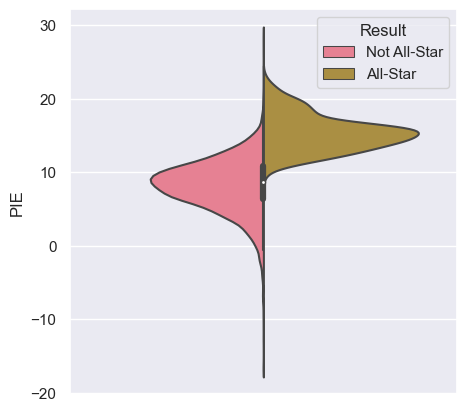

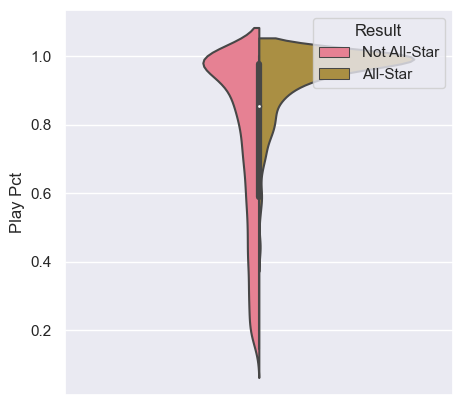

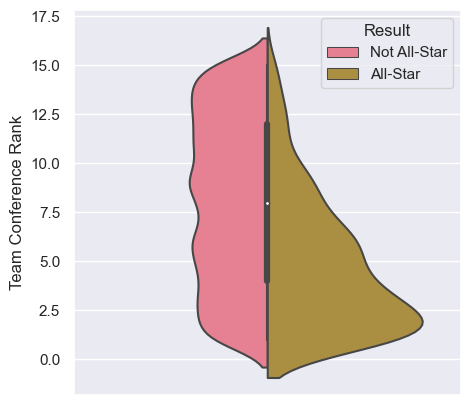

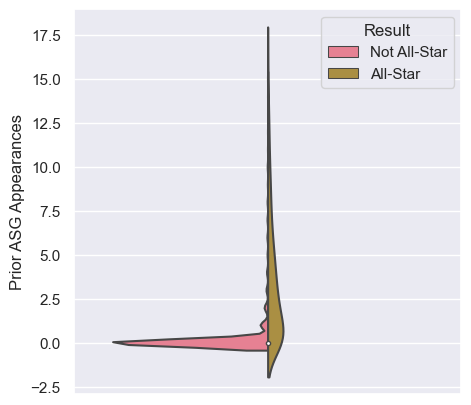

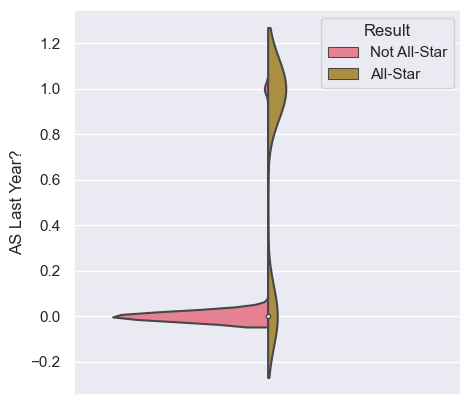

In [75]:
# Violin Plots
plt.style.use('default')
sns.set(style='darkgrid')
plt.rcParams['legend.title_fontsize'] = 'medium'

for feat in full_features:
    fig, ax = plt.subplots(figsize=(5,5))
    sns.violinplot(ax=ax, data=df_train, y=feat, x=[''] * len(df_train), hue='Selected?', split=True, palette=palette)
    ax.legend_.set_title('Result')
    new_labels = ['Not All-Star', 'All-Star']
    for t, l in zip(ax.legend_.texts, new_labels):
        t.set_text(l)
    feat = feat.replace('?', '').replace('%', '')
    plt.savefig('./Plots/{}-violinplot.png'.format(feat))
    plt.show()

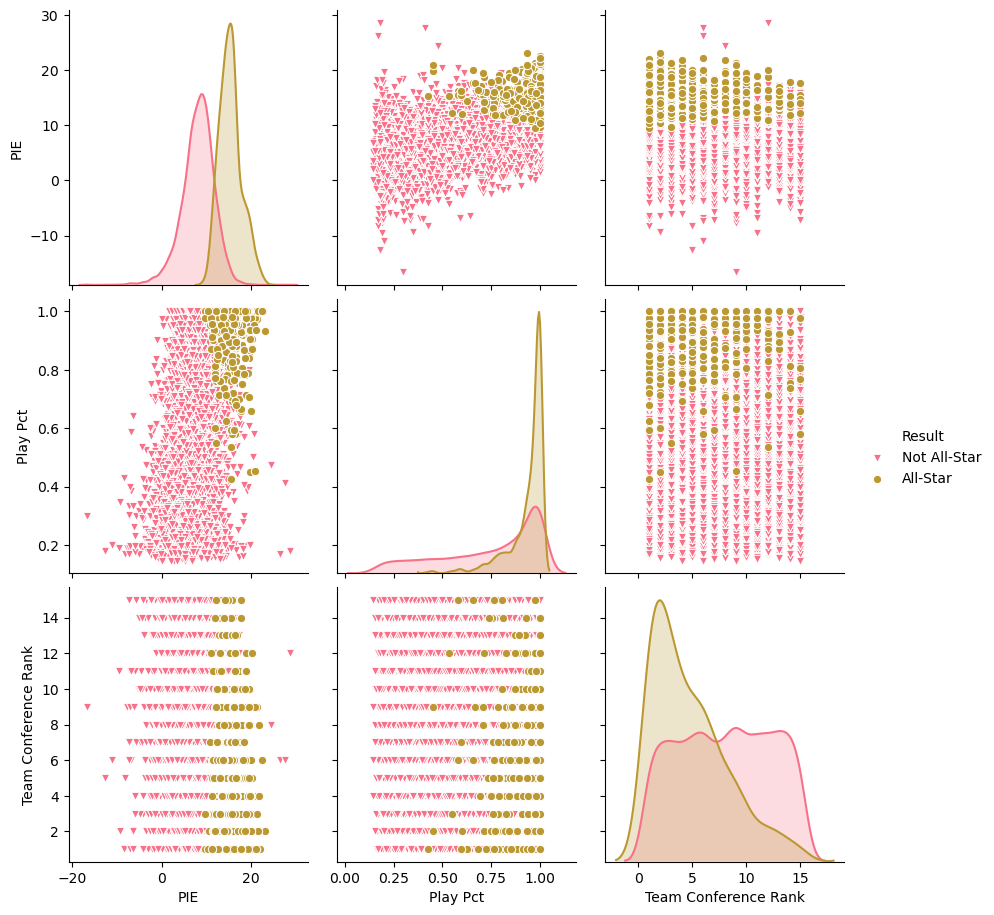

In [106]:
# Pair Plot
pairplot_features = [
    'PIE',
    'Play Pct',
    'Team Conference Rank'
]

ax = sns.pairplot(data=df_train, vars=pairplot_features, hue='Selected?', markers=['v', 'o'], palette=palette, size=3)
ax._legend.set_title('Result')
new_labels = ['Not All-Star', 'All-Star']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
plt.subplots_adjust(right=0.85)
plt.savefig('./Plots/scattermatrix.png')
plt.show()

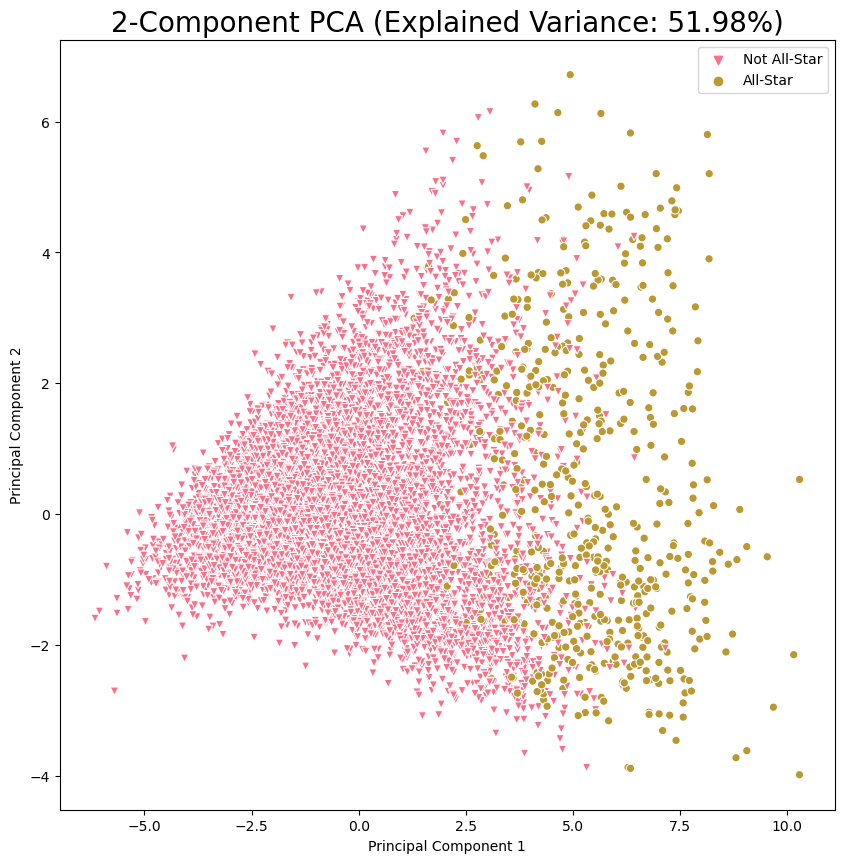

In [107]:
# Principal Component Analysis

pca = PCA(n_components=2)

X_pca = df_train[full_features].values
y_pca = df_train['Selected?'].values

X_pca = StandardScaler().fit_transform(X_pca)

components = pca.fit_transform(X_pca)
df_pca = pd.DataFrame(data=components, columns=['Principal Component 1',
                                                'Principal Component 2'])
df_pca['Result'] = y_pca

explained_variance = 100*sum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ax=ax, data=df_pca, x='Principal Component 1', y='Principal Component 2',
                markers=['v', 'o'], style='Result', hue='Result', palette=palette)
ax.set_title('2-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance), size=20)
new_labels = ['Not All-Star', 'All-Star']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=new_labels)
plt.savefig('./Plots/PCA.png')
plt.show()

# Partitioning Labelled Dataset

In [108]:
# split labeled data into 66% train, 17% validation, 17% test
train, not_train = train_test_split(df_train, train_size=0.66, stratify=df_train['Selected?'], shuffle=True, random_state=0)
validation, test = train_test_split(not_train, train_size=0.5, stratify=not_train['Selected?'], shuffle=True, random_state=0)

X_train, y_train = train[features], train['Selected?']
X_val, y_val = validation[features], validation['Selected?']
X_test, y_test = test[features], test['Selected?']

# Train the Model - XGBoost

In [109]:
if not already_trained_xgb:
    
    X_train_oversampled, y_train_oversampled = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)
    
    # range of learning rates we will consider
    learning_rates = [a * (10**b) for b in range(-6,-1) for a in range(1,10)] + [0.1]
    
    # maximum number of rounds we will consider
    max_n_estimators = 2500
    # number of rounds after which to terminate the process if no improvement is seen (patience)
    early_stopping_rounds = 10
    # maximum depth of the decision tree - kept very low to avoid overfitting and ensure a relatively "simple" model
    max_depth = 2
    
    best_learning_rate, best_ntree_limit = learning_rates[0], 1
    highest_auc = -float('inf')
    
    for learning_rate in learning_rates:
        
        model = XGBC(objective='binary:logistic', learning_rate=learning_rate,
                     n_estimators=max_n_estimators, max_depth=max_depth, tree_method=tree_method,
                     n_jobs=-1, random_state=0)
        model.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                  eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
        curr_auc = max(model.evals_result()['validation_1']['auc']) # AUC of the validation set
        if curr_auc > highest_auc:
            highest_auc, best_learning_rate, best_ntree_limit = curr_auc, learning_rate, model.best_ntree_limit
    
    # train the model with the optimal hyperparameters
    tuned_model_xgb = XGBC(objective='binary:logistic', learning_rate=best_learning_rate,
                     n_estimators=best_ntree_limit, max_depth=max_depth, tree_method=tree_method,
                     n_jobs=-1, random_state=0)
    tuned_model_xgb.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                  eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
    
    pickle.dump(tuned_model_xgb, open('ASG_predictor_XGB.model', 'wb'))
    

In [110]:
tuned_model_xgb = pickle.load(open('ASG_predictor_XGB.model', 'rb'))

# run the tuned model on the test set and get all-star prediction probabilities
y_test_proba = [prob[1] for prob in tuned_model_xgb.predict_proba(X_test)]

# shows model performance progress during training and how it fares with the test set
def show_model_evaluations_XGB():

    plt.style.use('bmh')

    results = tuned_model_xgb.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
    plt.title('XGBoost AUC ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    ax.legend()
    plt.savefig('./Plots/AUC-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Validation')
    plt.title('XGBoost Error% ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Error%')
    ax.legend()
    plt.savefig('./Plots/error-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.title('XGBoost Logarithmic Loss ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Log. Loss')
    ax.legend()
    plt.savefig('./Plots/logloss-training.png')
    plt.show()

    plt.style.use('default')
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    no_skill = [0] * len(y_test)
    fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test, no_skill)    
    ax.plot(fpr, tpr, label='XGBoost')
    ax.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
    plt.title('XGBoost Receiver Operating Characteristic\n(AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend()
    plt.savefig('./Plots/ROCAUC.png')
    plt.show()

    plt.style.use('default')
    plt.style.use('seaborn-deep')

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#FFFFFF', '#264d73'])
    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(tuned_model_xgb, X_test, y_test, cmap=cmap, display_labels=['Not AS', 'All Star'], normalize='true', ax=ax)
    plt.title('Normalized confusion matrix\n')
    plt.savefig('./Plots/confusion.png')
    plt.show()


def show_model_interpretation_XGB():
    
    # uses SHAP values to "explain" the model robustly
    # SHAP provides model inteprtation metrics that are accurate and consistent (unlike gain, cover or weight)
    explainer = shap.TreeExplainer(tuned_model_xgb)
    shap_values = explainer.shap_values(X_test)
    
    plt.style.use('seaborn-deep')

    shap.summary_plot(shap_values, X_test, plot_type='dot', plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.3)
    plt.title('Model SHAP Details')
    plt.savefig('./Plots/SHAP-Details.png')
    plt.show()

    shap.summary_plot(shap_values, X_test, plot_type='bar', color='#264d73', plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.22)
    plt.title('Model SHAP Summary')
    plt.savefig('./Plots/SHAP-Summary.png')
    plt.show()

    partial_dependence_features = ['PIE', 'Team Conference Rank', 'Play Pct']
    for i, feature in enumerate(partial_dependence_features):
        pdp_feature = pdp.pdp_isolate(model=tuned_model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature=feature)
        fig, ax = pdp.pdp_plot(pdp_feature, feature, figsize=(10,8))
        plt.savefig('./Plots/indiviual-pdp-{}.png'.format(i+1))
        plt.show()

        
def show_classification_metrics_XGB():

    # range of classification thresholds to consider
    thresholds = np.arange(0.1, 1, 0.0025)

    highest_f1_score = -float('inf')
    optimal_threshold = thresholds[0]
    
    for threshold in thresholds:
        y_pred = [0 if prob < threshold else 1 for prob in y_test_proba]
        curr_f1_score = f1_score(y_test, y_pred)
        if curr_f1_score > highest_f1_score:
            highest_f1_score = curr_f1_score
            optimal_threshold = threshold
    print('Optimal threshold: {}'.format(optimal_threshold))
        
    # our binary-forced predictions based upon our F1-score-optimized threshhold
    y_pred = [0 if prob < optimal_threshold else 1 for prob in y_test_proba]

    metrics = [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'Log. Loss',
        'ROC AUC'
    ]

    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        log_loss(y_test, y_test_proba),
        roc_auc_score(y_test, y_test_proba)
    ]

    df_classification_metrics = pd.DataFrame({'Metric' : metrics, 'Score' : scores}).set_index('Metric')

    return df_classification_metrics

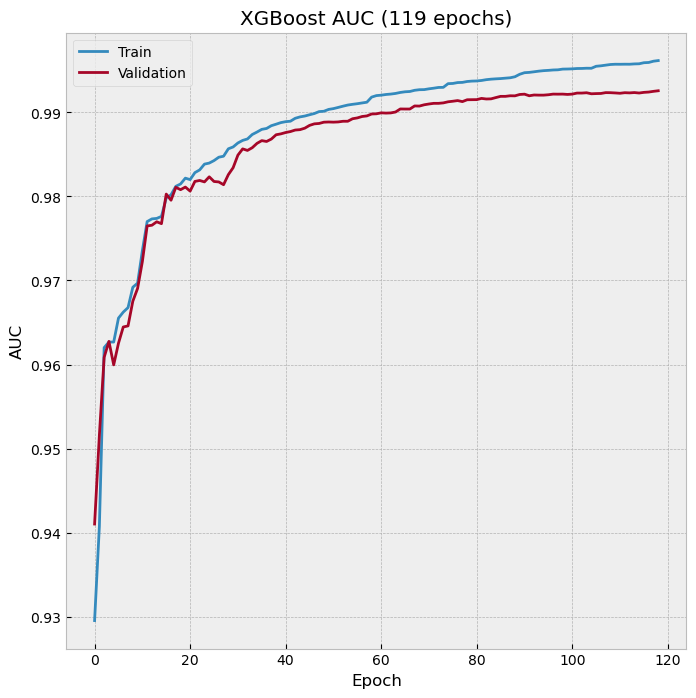

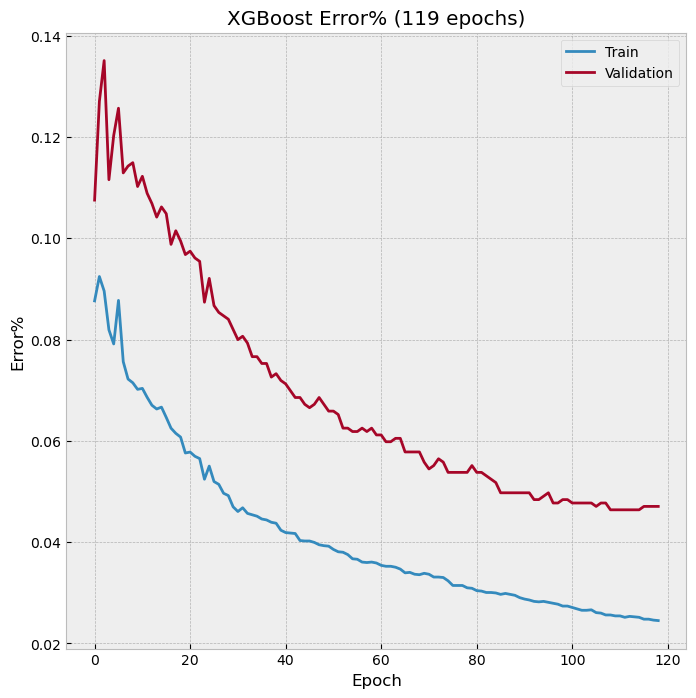

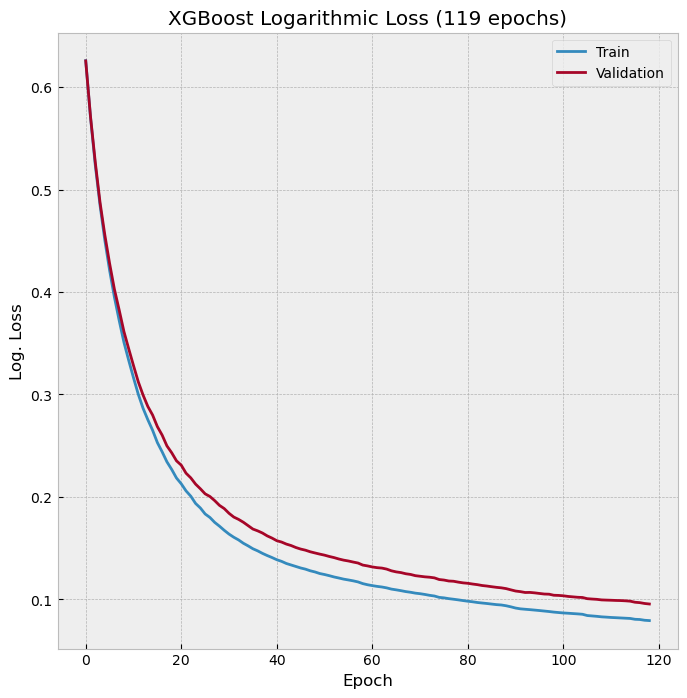

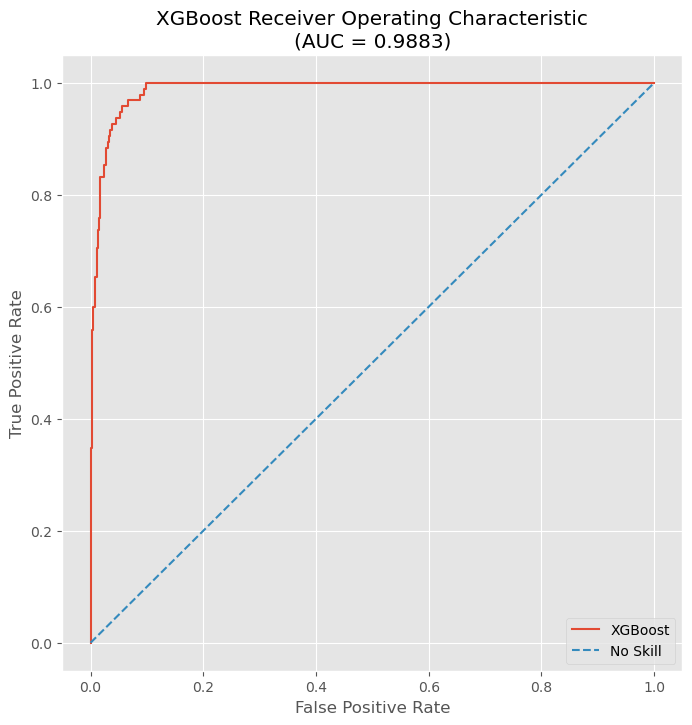

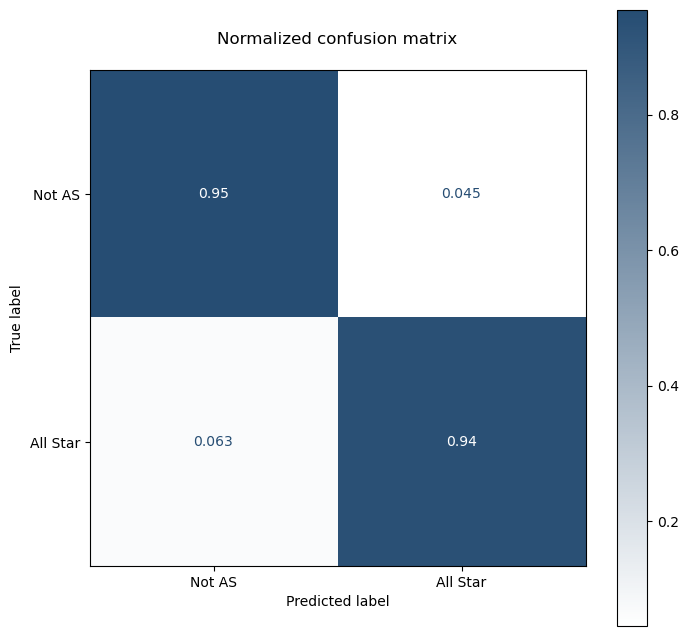

In [111]:
show_model_evaluations_XGB()

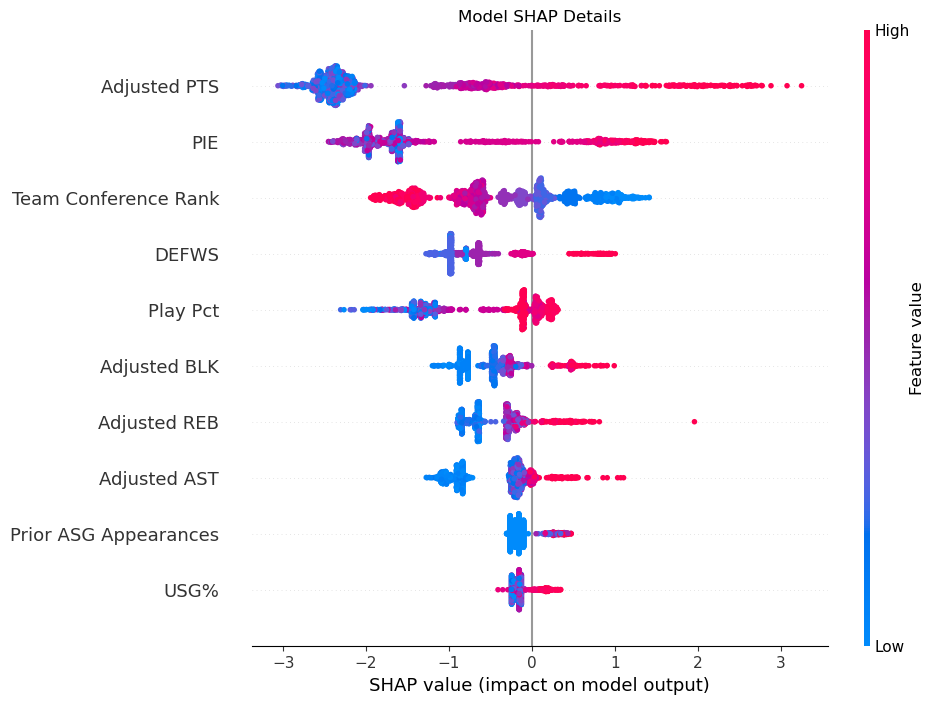

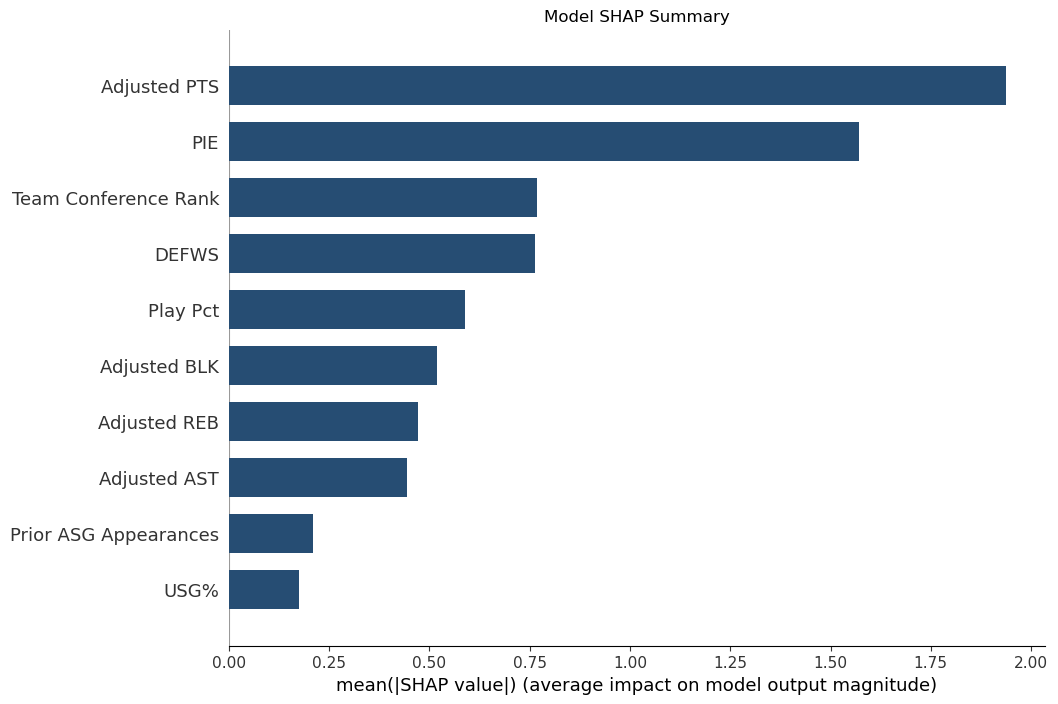

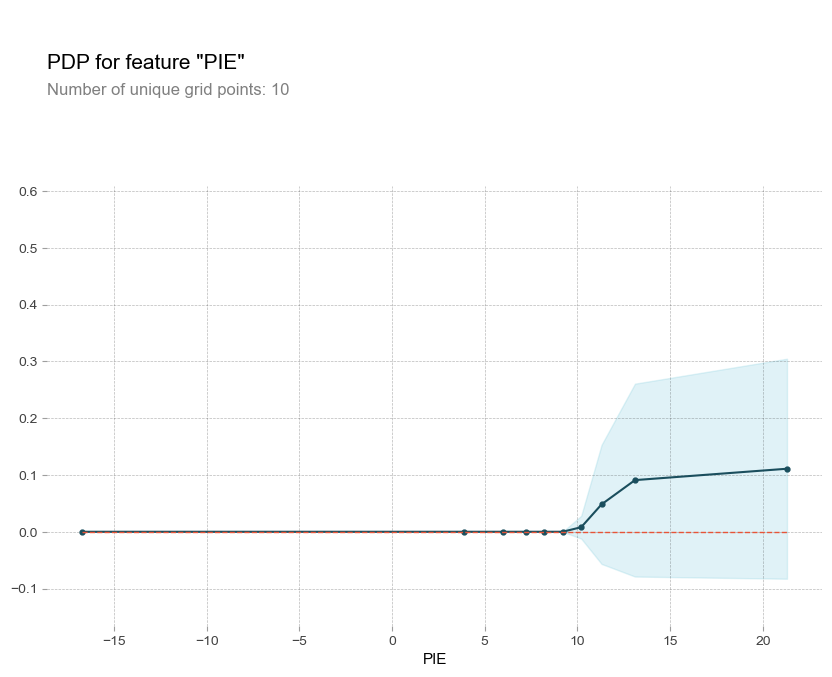

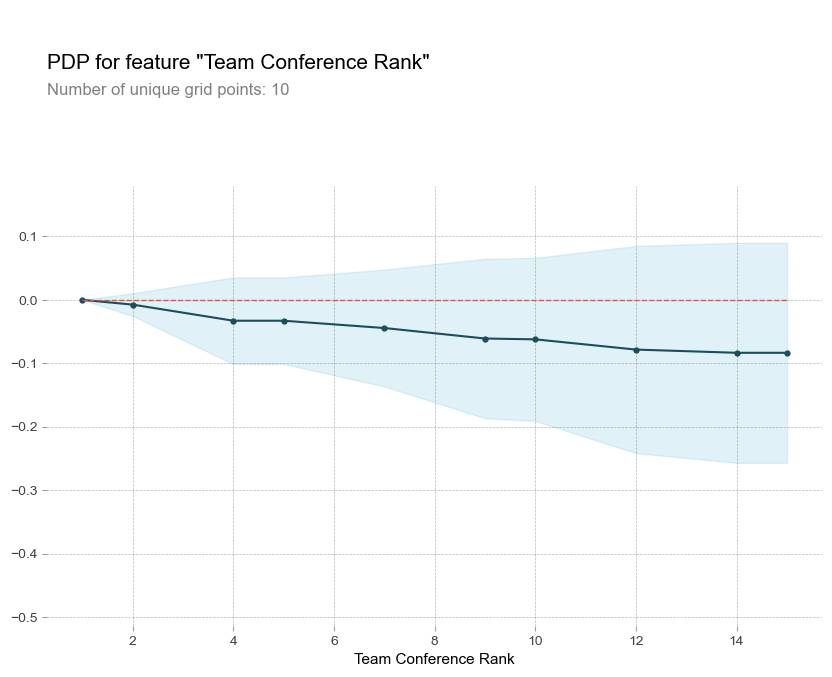

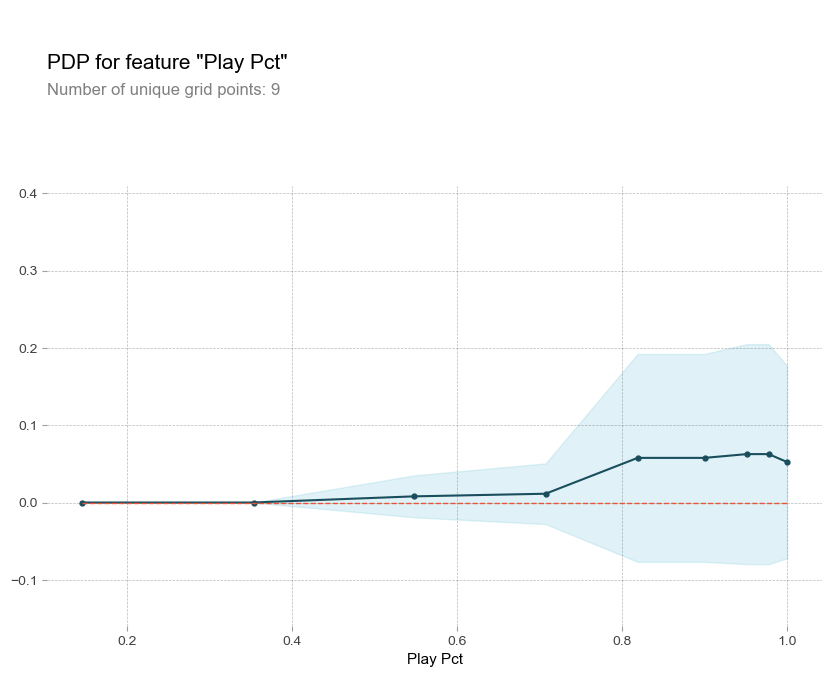

In [112]:
show_model_interpretation_XGB()

In [113]:
show_classification_metrics_XGB()

Optimal threshold: 0.8025000000000005


,Score
Metric,
Accuracy,0.973136
Precision,0.766990
Recall,0.831579
F1 Score,0.797980
Log. Loss,0.105293
ROC AUC,0.988273


# Model Application to Current Players - XGBoost

In [114]:
# The following section applies the tuned XGBoost model to all acrive players in the current season
# the calssification schema here takes the top 12 prediction probabilities from each conference, slightly
# different than our fixed threshold

df_to_predict_xgb = df_to_predict[features]
df_to_predict_xgb['AS Prob'] = [prob[1] for prob in tuned_model_xgb.predict_proba(df_to_predict_xgb)]

#saving this for later to do some case-by-case analysis
df_predictions = df_to_predict_xgb.copy().join(names_and_teams)

df_to_predict_xgb = df_to_predict_xgb.join(names_and_teams)[['PLAYER', 'TEAM', 'AS Prob']]

eastern_conf = set(['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA', 'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS'])
df_to_predict_xgb['Conf'] = df_to_predict_xgb['TEAM'].map(lambda x: 'East' if x in eastern_conf else 'West')

df_east = df_to_predict_xgb[df_to_predict_xgb['Conf'] == 'East'].sort_values('AS Prob', ascending=False).reset_index(drop=True)
df_west = df_to_predict_xgb[df_to_predict_xgb['Conf'] == 'West'].sort_values('AS Prob', ascending=False).reset_index(drop=True)

for df in [df_east, df_west]:
    df['Model Prediction'] = df.index.map(lambda x: 'Yes' if x < 12 else 'No')
    
df_east = df_east[['PLAYER', 'TEAM', 'Conf', 'AS Prob', 'Model Prediction']]
df_west = df_west[['PLAYER', 'TEAM', 'Conf', 'AS Prob', 'Model Prediction']]

# top x players from each conference to include in the summary
summary_conf_size = 25

df_results_summary = pd.concat([df_east.head(summary_conf_size), df_west.head(summary_conf_size)]).set_index('PLAYER')
df_results_full = pd.concat([df_east, df_west]).set_index('PLAYER').sort_values('AS Prob', ascending=False)

df_results_summary.to_csv('{}_NBA_ASG_predictor_XGBoost_results_summary.csv'.format(prediction_year))
df_results_full.to_csv('{}_NBA_ASG_predictor_XGBoost_results_full.csv'.format(prediction_year))

In [96]:
df_east.head(summary_conf_size).set_index('PLAYER')

,TEAM,Conf,AS Prob,Model Prediction
PLAYER,,,,
Giannis Antetokounmpo,MIL,East,0.996647,Yes
Jimmy Butler,MIA,East,0.976653,Yes
Khris Middleton,MIL,East,0.970948,Yes
Pascal Siakam,TOR,East,0.965004,Yes
Kemba Walker,BOS,East,0.958977,Yes
Bradley Beal,WAS,East,0.953880,Yes
Jayson Tatum,BOS,East,0.949880,Yes
Bam Adebayo,MIA,East,0.942731,Yes
Joel Embiid,PHI,East,0.941250,Yes


In [97]:
df_west.head(50).set_index('PLAYER')

,TEAM,Conf,AS Prob,Model Prediction
PLAYER,,,,
LeBron James,LAL,West,0.996275,Yes
Anthony Davis,LAL,West,0.992626,Yes
James Harden,HOU,West,0.990200,Yes
Kawhi Leonard,LAC,West,0.987165,Yes
Russell Westbrook,HOU,West,0.986435,Yes
Luka Doncic,DAL,West,0.985776,Yes
Damian Lillard,POR,West,0.978167,Yes
Rudy Gobert,UTA,West,0.970358,Yes
Donovan Mitchell,UTA,West,0.968635,Yes
